# import libraries

In [73]:
import numpy as np 
import pandas as pd 
import datetime
from matplotlib import pyplot as plt

# import data

In [74]:
data = pd.read_csv('moniflora.csv')
data.describe()

,battery,conductivity,light,moisture,temperature,timestamp
count,2695.000000,2695.000000,2695.000000,2695.000000,2695.000000,2.695000e+03
mean,73.217811,2102.319481,996.339889,40.411503,29.146160,1.715171e+12
std,31.531563,827.349404,1414.100252,9.819995,2.034633,1.109281e+09
min,27.000000,325.000000,0.000000,0.000000,22.000000,1.714410e+12
25%,33.000000,1581.500000,0.000000,32.000000,27.700000,1.714619e+12
50%,90.000000,1928.000000,56.000000,38.000000,28.800000,1.715047e+12
75%,100.000000,2478.000000,1677.000000,50.000000,30.500000,1.715377e+12
max,100.000000,4829.000000,6740.000000,93.000000,33.900000,1.721559e+12


# Aim of this notebook
The aim of this work is to build a warning system that can detect this cherry tomato's health status and make suggestions to cultivators to better enhacne this plant's wellbeing. 

From this notebook [cherry_tomato_prediction](https://www.kaggle.com/code/adastroabyssosque/cherry-tomato-prediction), this dataset doesn't contain null values. So we can jump right into keeping the only information we need.

## Assumption
All data are produced from one plant

# initial data processing

In [75]:
# drop unnecessary columns first
data = data.drop(['battery', 'createdAt', 'bioname', 'localname', 'id'], axis=1)

## convert timestamp to datetime

In [76]:
data.head()

,conductivity,light,moisture,temperature,timestamp
0,1872,3821,45,26.1,1714410192257
1,1928,4121,38,26.1,1714410495991
2,1809,3521,45,28.3,1714410798954
3,1892,4221,45,26.0,1714411103232
4,1883,4230,48,26.5,1714411407162


In [77]:
data['time'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).replace(microsecond=0))
data = data.drop('timestamp', axis=1)

# Feature Engineering

We're going to generate some new features/modify our exisited features: 
- create new featuresalinity (in ppm): roughly $0.55\times conductivity$ from this link: [Measuring Salinity](https://www.landscape.sa.gov.au/mr/publications/measuring-salinity#:~:text=Conversion%20for%20units%20used%20to%20measure%20salinity:&text=Simply%20times%20(x)%20EC%20(,55.)
- convert EC's unit to (mS/cm) (simply divide it by 1,000)
- create new feature eneergy_omitted (from a light source). This is roughly estimated by $ 0.0079\times light$ (formula from this link: [Howto convert solar intensity in LUX to watt per meter square for sunlight?](https://www.researchgate.net/post/Howto_convert_solar_intensity_in_LUX_to_watt_per_meter_square_for_sunlight#:~:text=multiply%20lux%20to%200.0079%20which%20give%20you%20value%20of%20w%2Fm2.))

In [78]:
data['salinity'] = 0.55*data['conductivity']
data['conductivity'] = data['conductivity']/1000

In [79]:
data['energey ommited'] =  0.0079*data['light']

In [80]:
data.describe()

,conductivity,light,moisture,temperature,time,salinity,energey ommited
count,2695.000000,2695.000000,2695.000000,2695.000000,2695,2695.000000,2695.000000
mean,2.102319,996.339889,40.411503,29.146160,2024-05-08 22:19:46.720593664,1156.275714,7.871085
min,0.325000,0.000000,0.000000,22.000000,2024-04-30 03:03:12,178.750000,0.000000
25%,1.581500,0.000000,32.000000,27.700000,2024-05-02 13:01:12.500000,869.825000,0.000000
50%,1.928000,56.000000,38.000000,28.800000,2024-05-07 11:54:52,1060.400000,0.442400
75%,2.478000,1677.000000,50.000000,30.500000,2024-05-11 07:44:51.500000,1362.900000,13.248300
max,4.829000,6740.000000,93.000000,33.900000,2024-07-21 20:52:08,2655.950000,53.246000
std,0.827349,1414.100252,9.819995,2.034633,NaN,455.042172,11.171392


In [81]:
# sort our data 
data = data.sort_values(by='time')

# more focus on moisture

We can see that there're values of 0 in the `moisture` column. The question is whether this is due to error.

{'whiskers': [<matplotlib.lines.Line2D at 0x1d5d52be7a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d5d52be260>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d5d52bea40>],
 'medians': [<matplotlib.lines.Line2D at 0x1d5d52bdd20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d5d52bda80>],
 'means': []}

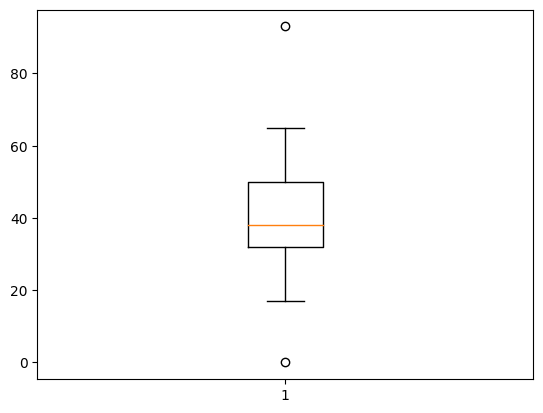

In [82]:
plt.boxplot(data['moisture'])

In [83]:
data.loc[data['moisture']==0]

,conductivity,light,moisture,temperature,time,salinity,energey ommited
1343,0.325,233,0,28.3,2024-05-07 11:34:38,178.75,1.8407


In [84]:
data.loc[[1342, 1343, 1344]]

,conductivity,light,moisture,temperature,time,salinity,energey ommited
1342,4.613,1010,60,28.3,2024-05-07 11:33:24,2537.15,7.9790
1343,0.325,233,0,28.3,2024-05-07 11:34:38,178.75,1.8407
1344,3.952,1107,38,28.4,2024-05-07 11:39:41,2173.60,8.7453


We can now conclude that it's more likely due to an error. Since the timing is also close, we'll drop this data

In [85]:
data = data.drop(index=1343, axis=0)

In [91]:
data = data.reset_index(drop=True)